# 18. 딥러닝 들여다보기


신경망이란 무엇일까

우리 뇌에서는 1000억개에 가까운 신경계 뉴런들이 있다고 함

서로 매우 복잡하게 얽혀있고, 조금 물러서서 보면 하나의 거대한 그물망과 같다. 우리는 이를 신경망이라고 부름

머신러닝과 딥러닝 과학자들도 우리 뇌 속의 신경망 구조에 착안해서 퍼셉트론(Perceptron)이라는 형태를 제안하며 이를 연결한 형태를 인공신경망이라고 부르기 시작했음

# 신경망 구성 (1) 개요

## MNIST Revisited

MNIST라는 숫자 이미지 데이터셋

딥러닝 프레임워크로 이미지 분류기를 만들수가 있음
MNIST이미지 분류기 모델이 어떻게 구성되었는지 기억을 되짚어 봅시당!

- Tensorflow기반 분류 모델 예시 코드

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터를 로드하자
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 모델에 맞게 데이터 가공하자
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
x_train_reshaped = x_train_norm.reshape(-1, x_train_norm.shape[1]*x_train_norm.shape[2])
x_test_reshaped = x_test_norm.reshape(-1, x_test_norm.shape[1]*x_test_norm.shape[2])

# 딥러닝 모델 구성 - 2 Layer Perceptron
model=keras.models.Sequential()
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))  # 입력층 d=784, 은닉층 레이어 H=50
model.add(keras.layers.Dense(10, activation='softmax'))   # 출력층 레이어 K=10
model.summary()

# 모델 구성과 학습
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train_reshaped, y_train, epochs=10)

# 모델 테스트 결과
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

11501568/11490434 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4988 - accuracy: 0.8818
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2258 - accuracy: 0.9361
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1758 - accuracy: 0.9501
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0

이미 지난번에 Conv2D같은 이미지 분류 특화 모델을 사용해봤지만 오늘은 기본적인 신경망 형태인 다층 퍼셉트론을 이용해서 간단하게 구현했음

뇌속의 뉴런이 1000억개라지만 위에서 만든 모델은 굳이 Conv2D를 사용하지 않았느너데도 39,760 파라미터만으로 테스트 성능이 97%정도가 나온당

프레임 워크 내부에서 일어나는 일을 numpy를 활용해 직접 구현하고 이해해보자!


## 다층 퍼셉트론 Overview

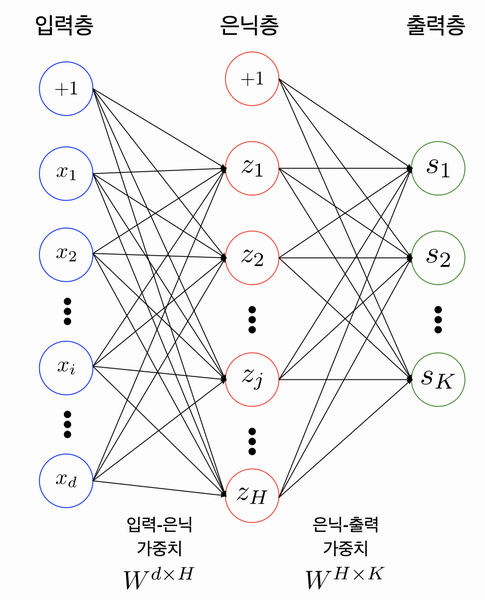

총 3개의 레이어로 구성된 퍼셉트론이다.

- 은닉층에는 H개의 노드가, 출력층에는 K개의 노드가 존재하는 인공신경망을 표현
- 위의 코드에서는 H=50, k=10, 입력층 노드 개수 d=784로 정의
- 입력층, 출력층 사이에 은닉층(hidden layer)이 있음
- 실제로는 3개가 아닌 총 2개의 레이어가 존재함
- 인공신경망 중에서 2개 이상의 레이어를 쌓아서 만든것을 보통 다층 퍼셉ㅌ트론이라고 부른다(multi-layer perceptron: MLP
- 은닉층이 많아질수록 DEEP해졌다고 한당
- 딥러닝은 여기서 나온 것!!! 충분히 깊은 인공신경망을 활용하며 이를 보통 다른 단어로 DNN(Deep Neural Network)라고 함

정리하자면 입력과 출력층 사이에 은닉층이 존재하는데, 이것이 많을 수록 신경망이 깊어지며, 깊은 인공신경망을 활용하는 학문이 딥러닝이다.


## Parameters/Weights

- 각각의 층 사이에는 행렬(Matrix)가 존재한다.

- 입력값이 100개, 은닉 노드가 20개라면 사실 그 사이에는 100x20의 형태를 가진 행렬이 존재함

- 10개의 클래스를 맞추는 문제를 풀기 위해 츨력층이 10개의 노드라면 은닉-출력 사이에는 20x10행렬이 있음

- 이 행렬들을 parameter or weight라고 부른다! *파라미터에는 bias 노드도 포함된다고 함

- 이때 인접한 레이어 사이에는 y=W*X+b 관계가 성립

위에서 만든 MLP 기반 딥러닝 모델을 Numpy로 다시 만들어보자 --

In [4]:
# 입력층 데이터 모양
print(x_train_reshaped.shape)

# 테스트를 위해 x_train_reshaped의 앞 5개 데이터 가져옴
X = x_train_reshaped[:5]
print(X.shape)

(60000, 784)
(5, 784)


In [5]:
weight_init_std = 0.1
input_size = 784
hidden_size=50

# 인접 레이어간 관계를 나타내는 파라미터 W를 생성하고 random 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)  
# 바이어스 파라미터 b를 생성하고 Zero로 초기화
b1 = np.zeros(hidden_size)

a1 = np.dot(X, W1) + b1   # 은닉층 출력

print(W1.shape)
print(b1.shape)
print(a1.shape)

(784, 50)
(50,)
(5, 50)


In [6]:
# 은닉층 첫번째 데이터 (50 dim 벡터)
a1[0]

array([ 0.15624565, -1.17852636, -0.81143424,  0.24987224, -0.36518314,
        0.52679566, -1.54843794,  2.14211573, -0.69443638,  1.09352946,
        1.35819324,  0.91719745,  0.58339061,  0.92968046, -0.3062713 ,
       -1.68944164,  0.34465817, -0.02263797,  0.67438548,  0.12631086,
        0.78321412, -0.82610305, -0.41672336,  2.0154466 , -0.36301077,
       -0.12678172, -0.17766902, -0.41068838, -0.12243309,  0.14234376,
       -1.21127311,  1.05528747, -0.44937008,  0.14821934,  0.55022101,
        0.95352667,  0.02750428, -2.01386024,  0.69385929,  1.5526481 ,
        0.36687793,  0.45134634, -1.370639  , -0.84436648, -0.59827634,
       -0.34204024,  0.92892264,  0.15646727, -0.31949998, -1.10108766])

# 신경망 구성 (2) 활성화 함수, 손실함수

## 활성화 함수(Activation Functions)

- MLP의 다른 중요요소
- 비선형 함수를 사용하기 때문에 mlp안에 포함시키면 모델의 표현력이 좋아진다

활성화 함수의 종류에 대해 알아보자!

### 1. sigmoid

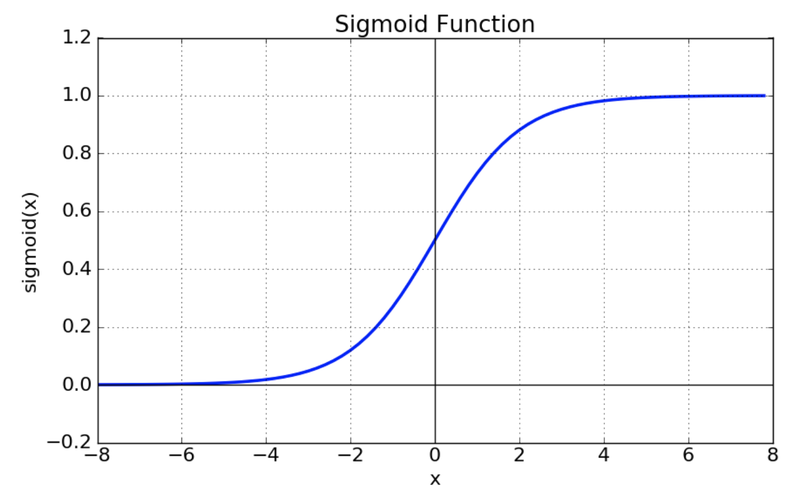

이전에 시그모이드를 사용한 적이 있다



```
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))
```

첫번째 은닉층의 출력 a1에다가 sigmoid를 적용해보자



In [7]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

s1 = sigmoid(a1)
print(s1[0]) # sigmoid 출력은 0-1사이

[0.53898214 0.23531726 0.30758495 0.56214506 0.40970545 0.62873544
 0.17531199 0.89492972 0.33304691 0.74904576 0.79546589 0.71447072
 0.64184721 0.71701045 0.42402513 0.15584928 0.5853216  0.49434075
 0.66248444 0.5315358  0.68637242 0.30446969 0.39730109 0.88240936
 0.41023094 0.46834696 0.45569922 0.39874707 0.46942991 0.53552598
 0.22947587 0.74178894 0.38951054 0.53698715 0.63418686 0.72182387
 0.50687564 0.11775535 0.6668249  0.82529587 0.59070436 0.61095929
 0.20251663 0.30061595 0.35473814 0.41531396 0.71685666 0.53903721
 0.42079761 0.24953616]


현재는 ReLU 함수를 더 많이 사용함

- vanishing gradient 현상이 발생한다고 함
- exp함수 사용시 비용이 크다

라는 이유로 sigmoid가 ReLU한테 밀림

### 2. Tanh

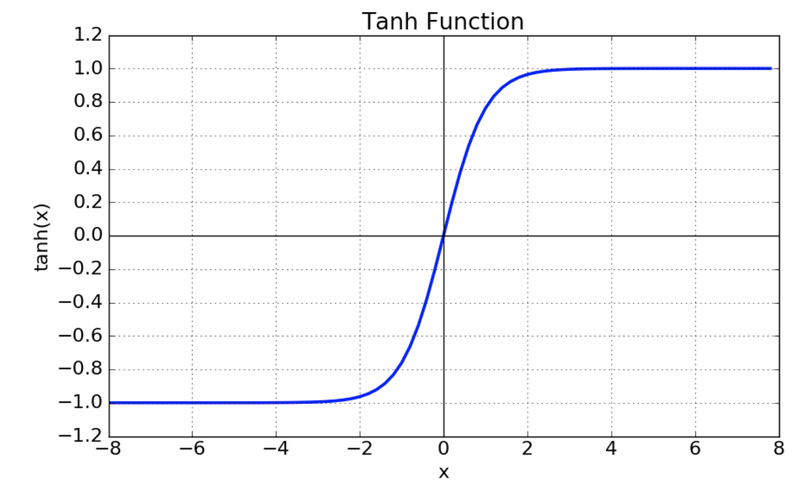

- 함수의 중심값을 0으로 옮겨 sigmoid의 최적화 과정이 느려지는 문제를 해결함

- vanishing gradient 문제 존재


### 3. ReLU

f(x) = max(0, x)

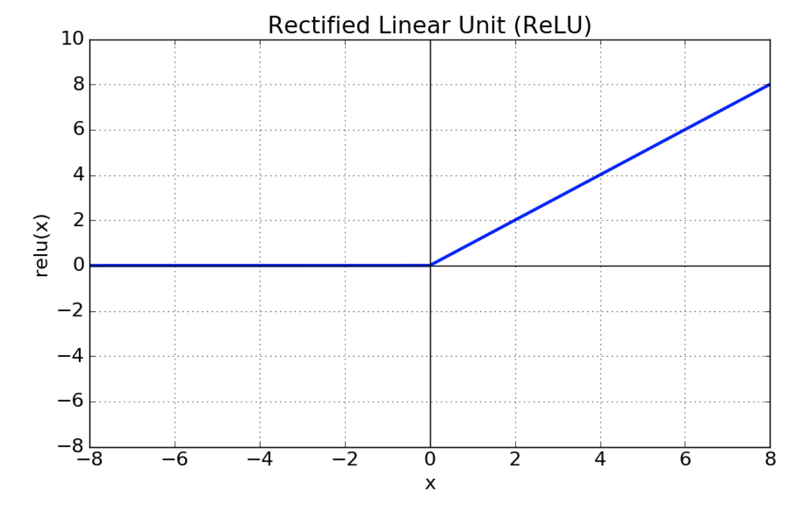

- 다른 함수에 비해 학습이 빠르다
- 연산 비용이 작고, 구현이 간단



####딥러닝 네트웤에서는 보통 노드에 들어오는 값을 곧바로 다음 레이어로 전달이 아니라 비선형 함수를 통과시킨 후 전달 

- 이때 사용하는 함수가 활성화 함수
- 왜 선형함수가 아니라 비선형함수를???
    - 선형함수인 f(x) = cx를 썼다고 생각해보자. 식으로 나타내면 y(x) = f(f(f(x))). 결국 y(x) = c3*x 
    - 은닉층이 없는 네트워크로 표현 가능
    - 뉴럴네트워크에서 층을 쌓으려면 활성화함수는 반드시 비선형 함수 !!


결론

1. 시그모이드

 - 함수값이 0, 1로 제한되고 중간값은 1/2
 - gradient vanishin 현상이 있다
 - 함수값 중심이 0이 아니라서 학습이 느려질 수 있음
 - exp 함수 사용시 비용이 큼

2. tanh

 - 함수의 중심값을 0으로 옮겨 좀더 빠름
 - 미분함수에 대해 일정값 이상 커질 시 미분값이 소실되는 gradient vanishing 이 발생

3. ReLU

  - x > 0이면 기울기가 1인 직선
  - x < 0이면 함수값이 0이 된다
  - 학습 빠름, 연산 비용 적음, 구현 간단
  - x < 0 인 값에 대해서는 기울기가 0이기 때문에 뉴런이 죽을 수 있다는 단점

4.  Exponential Linear Unit(ELU)

  - ELU는 비교적 가장 최근에 나온 함수이다.
  - ReLU의 모든 장점을 포함한다.
  - “Dying ReLU” 문제를 해결했다.
  - 출력값이 거의 zero-centered에 가깝다
  - 일반적인 ReLU와 달리 exp함수를 계산하는 비용이 발생한다. 

5. Leakly ReLU, PReLU 등등
 

여러 활성화 함수가 있지만 젤 많이 쓰는 건 ReLU 어제도 봤다
이 계열의 다른 함수도 써보삼
시그모이드나 tanh은 비추

참고 https://reniew.github.io/12/

시그모이드 다음에 Dense레이어가 출현한다 출력 노드 개수만 다를뿐 동일한 구조 

MLP레이어를 함수로 구현해보자!

In [8]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

print('go~')

go~


In [10]:
input_size = 784 
hidden_size = 50
output_size = 10 

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)    # z1이 다시 두번째 레이어의 입력

print(a2[0])  # 최종 출력 = output_size만큼의 벡터

[-0.39768887 -0.05110714 -0.69116647  0.63952924 -0.11709155 -0.73583069
  0.20025773  0.45149608  0.88513793 -0.08295924]


In [11]:
def softmax(x): # 최종 출력인 a2에 softmax 함수를 적용해보자
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [12]:
y_hat = softmax(a2)
y_hat[0]  # 모델 출력은 x가 10개의 숫자 중 하나일 확률의 형태로 가공된다

array([0.05830532, 0.08245684, 0.04347629, 0.16450013, 0.0771916 ,
       0.04157718, 0.10602129, 0.13630271, 0.21029684, 0.0798718 ])

## 손실함수 (Loss Functions)

은닉층 - 출력층으로 전달될 때 정답과 신호 정보들 사이 차이를 계산하고 줄이기 위해 파라미터를 조정하는게 학습 흐름

이 차이를 구하는데 사용되는 함수가 손실함수
대표적으로 2개가 있다

1) 평균제곱오차

2) 교차 엔트로피

#### 교차 엔트로피

- 오늘 사용할 손실함수
- 두 확률분포 사이의 유사도가 클수록 작아지는 값

In [13]:
# 정답 라벨을 One-hot 인코딩하는 함수
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
        
    return T

Y_digit = y_train[:5]
t = _change_one_hot_label(Y_digit, 10)
t

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [14]:
print(y_hat[0])
print(t[0])

[0.05830532 0.08245684 0.04347629 0.16450013 0.0771916  0.04157718
 0.10602129 0.13630271 0.21029684 0.0798718 ]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


모델의 최종 출력인 softmax(a2)와 정답 라벨의 원핫인코딩의 분포가 유사해지도록 한다

In [15]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

Loss = cross_entropy_error(y_hat, t)
Loss

2.7136976458366893

# 경사하강법


오차를 구한 후 다음 단계 = 오차를 줄인다

-> 경사하강법 (gradient Descent)
- 각 단계에서의 기울기를 구해서 기울기가 가리키는 방향으로 이동하는 방법
- 학습률(learning rate)를 도입해 기울기 값과 이 학습률을 곱한 만큼만 간다
- parameter 값 초기화
- x-y좌표축 기울기 = x의 변화량에 따른 y의 변화량, y를 x로 미분해서 구한다

  1. 파라미터 w의 변화에 따른 오차 L의 변화량을 구한다. 
  2. 오차 기울기가 커지는 뱡향의 반대로 파라미터를 조정
  3. 적절한 step size 역할의 learning rate 사용

Numpy로 구현해보자 !

In [16]:
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num 
dy    # softmax값의 출력으로 Loss를 미분한 값

array([[ 0.01166106,  0.01649137,  0.00869526,  0.03290003,  0.01543832,
        -0.19168456,  0.02120426,  0.02726054,  0.04205937,  0.01597436],
       [-0.18771869,  0.01429195,  0.00817228,  0.0362695 ,  0.01519547,
         0.01035065,  0.02393925,  0.02937432,  0.0347965 ,  0.01532876],
       [ 0.01098835,  0.0180212 ,  0.00910614,  0.03411586, -0.18411343,
         0.00948834,  0.02325184,  0.02716992,  0.03614943,  0.01582235],
       [ 0.00963701, -0.18400604,  0.0091209 ,  0.03331973,  0.01700996,
         0.00907599,  0.02142769,  0.02944754,  0.03768632,  0.0172809 ],
       [ 0.01190969,  0.0131861 ,  0.00992718,  0.03133497,  0.01851879,
         0.0091606 ,  0.02166172,  0.02618918,  0.04232423, -0.18421246]])

In [17]:
dW2 = np.dot(z1.T, dy)    
dW2

array([[-0.06059383, -0.05279744,  0.01855344,  0.0690577 , -0.07287236,
        -0.02933526,  0.04603231,  0.05722909,  0.07835784, -0.05363149],
       [-0.1324062 , -0.03454965,  0.02688585,  0.10164686, -0.08094818,
        -0.07142191,  0.06768839,  0.08382811,  0.11485093, -0.07557421],
       [-0.14292626, -0.0708857 ,  0.03040546,  0.11573698, -0.07340024,
        -0.11365511,  0.07664594,  0.09583331,  0.13075391, -0.04850829],
       [-0.04028727, -0.04358192,  0.01567234,  0.05909029, -0.07796954,
        -0.05729997,  0.03919058,  0.04887851,  0.06678583, -0.01047887],
       [-0.04906315, -0.06186659,  0.01907355,  0.07119799, -0.01902552,
        -0.11142212,  0.04694439,  0.05940767,  0.08327562, -0.03852184],
       [-0.01801172, -0.06856287,  0.02216538,  0.08060458, -0.05813039,
        -0.09559594,  0.05353873,  0.06720789,  0.09547037, -0.07868603],
       [-0.12339365, -0.13705687,  0.02638342,  0.09922649,  0.01495504,
        -0.07282454,  0.06542042,  0.08330641

같은 방식으로 우리가 학습해야 할 모든 파라미터 W1, b1, W2, b2에 대한 기울기를 모두 얻을 수 있다



In [18]:
dW2 = np.dot(z1.T, dy)
db2 = np.sum(dy, axis=0)

중간에 sigmoid가 한번 사용되었으므로, 활성화함수에 대한 gradient도 고려한다



In [20]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [21]:
dz1 = np.dot(dy, W2.T)
da1 = sigmoid_grad(a1) * dz1
dW1 = np.dot(X.T, da1)
db1 = np.sum(dz1, axis=0)

In [23]:
# 파라미터 업뎃 함수, learning_rate 지정
learning_rate = 0.1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

# 오차역전파법 

손실함수를 통해 구한 오차를 가지고 각 파라미터를 조정할 때, 기울기를 어떻게 입력층까지 전달할 수 있을까..?

-> 오차역전파법

- MLP를 학습시키기 위한 일반적인 알고리즘 중 하나
- 출력층의 결과와 target값의 차이를 구한 뒤, 각 레이어들을 반대로 지나며 각 노드가 가진 변수들을 갱신해나간다!

8번의 affine_layer_forword(X,W,b)에 대응해서 backpropagation 함수를 만들어보자


In [25]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

정리된 내용을 바탕으로 Forward Propagation과 Backward Propagation이 이루어지는 한 사이클을 만들면



In [26]:
# 파라미터 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

# Forward Propagation
a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)

# 추론과 오차(Loss) 계산
y_hat = softmax(a2)
t = _change_one_hot_label(Y_digit, 10)   # 정답 One-hot 인코딩
Loss = cross_entropy_error(y_hat, t)

print(y_hat)
print(t)
print('Loss: ', Loss)
        
dy = (y_hat - t) / X.shape[0]
dz1, dW2, db2 = affine_layer_backward(dy, cache2)
da1 = sigmoid_grad(a1) * dz1
dX, dW1, db1 = affine_layer_backward(da1, cache1)

# 경사하강법을 통한 파라미터 업데이트    
learning_rate = 0.1
W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

[[0.10439458 0.13613391 0.07112755 0.13438827 0.07119239 0.04629088
  0.03325658 0.16684872 0.10328425 0.13308286]
 [0.11493352 0.13006452 0.08574662 0.12192466 0.08347914 0.05627467
  0.04989594 0.13309024 0.08163354 0.14295714]
 [0.11246121 0.17511228 0.06154863 0.10498228 0.0804274  0.05206201
  0.04749199 0.15268342 0.08712402 0.12610676]
 [0.11872306 0.19166721 0.0793737  0.09096098 0.07144714 0.0454476
  0.04179773 0.16218649 0.07952083 0.11887527]
 [0.12479264 0.12450125 0.0750329  0.12823674 0.06837396 0.05475604
  0.04744093 0.15545519 0.09202063 0.1293897 ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.290706631504899


# 모델 학습 step by step

파라미터 업뎃 과정을 다섯 스텝 반복해보자

In [28]:
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1) # forward
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2) 
    t = _change_one_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat) # 추론한 확률값
        print(t)     # 정답의 one-hot 인코딩 값
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2) # backward
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [29]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.13739027 0.07741617 0.07260163 0.11268072 0.09466357 0.15333761
  0.0767915  0.05987126 0.11377335 0.10147393]
 [0.11292552 0.07671761 0.08105301 0.09640807 0.0940421  0.20227062
  0.07627128 0.04959496 0.12092832 0.0897885 ]
 [0.1196592  0.1099425  0.08197944 0.09206901 0.09427717 0.18647948
  0.06795322 0.05647401 0.10792035 0.08324562]
 [0.12804997 0.08623688 0.06966913 0.09938982 0.09532299 0.17921885
  0.06519915 0.05931024 0.13385436 0.0837486 ]
 [0.12817133 0.08408012 0.08627127 0.11477903 0.09796964 0.16206519
  0.071645   0.05195436 0.10225505 0.10080901]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.232568230534039
---------
[[0.15362687 0.08778324 0.06365444 0.09510608 0.10534128 0.16334476
  0.06765244 0.05396507 0.09396019 0.11556564]
 [0.13155727 0.08763267 0.07063751 0.0806186  0.10645086 0.2076162
  0.06733804 0.04475635 0.09932

모델이 추론한 확률값 y-hat이 정답의 원핫인코딩 t값에 조금씩 근접
로스가 계속 줄어든당

= 경사하강법을 통해 조금씩 파라미터를 제대로 업뎃하고 있다

# 추론 과정 구현과 정확도(Accuracy)계산


방금 5번 학습한 파라미터 W1, b1, W2, b2로 숫자를 인식(Predict)해 보고, 그 정확도(Accuracy)를 측정할 수 있다






In [34]:
# 추론 함수
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [35]:
# X = x_train[:100] 에 대해 모델 추론을 시도
X = x_train_reshaped[:100]
Y = y_test[:100]
result = predict(W1, b1, W2, b2, X)
result[0]

array([0.19034011, 0.11583385, 0.03888835, 0.05392493, 0.13040585,
       0.1921367 , 0.04164389, 0.03519921, 0.05047989, 0.15114723])

In [36]:
# 정확도 함수
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

In [37]:
acc = accuracy(W1, b1, W2, b2, X, Y)

t = _change_one_hot_label(Y, 10)
print(result[0])
print(t[0])
print(acc)

[0.19034011 0.11583385 0.03888835 0.05392493 0.13040585 0.1921367
 0.04164389 0.03519921 0.05047989 0.15114723]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.06


6퍼 ..??라니 ㅠㅠ

# 전체 학습 사이클 수행

전체 학습 과정이 구현된 코드를 볼 시간

아래는 학습시킬 파라미터를 초기화하는 함수!



In [38]:
def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):

    W1 = weight_init_std * np.random.randn(input_size, hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std * np.random.randn(hidden_size, output_size)
    b2 = np.zeros(output_size)

    print(W1.shape)
    print(b1.shape)
    print(W2.shape)
    print(b2.shape)
    
    return W1, b1, W2, b2

본격적으로 진행해봅시당.. GPU를 사용하지 않기 때문에 시간이 걸린다!

In [40]:
# 하이퍼파라미터
iters_num = 50000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 50, 10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train_reshaped[batch_mask]
    y_batch = y_train[batch_mask]
    
    W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate=0.1, verbose=False)

    # 학습 경과 기록
    train_loss_list.append(Loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        print('Loss: ', Loss)
        train_acc = accuracy(W1, b1, W2, b2, x_train_reshaped, y_train)
        test_acc = accuracy(W1, b1, W2, b2, x_test_reshaped, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

(784, 50)
(50,)
(50, 10)
(10,)
Loss:  2.303693150453007
train acc, test acc | 0.09868333333333333, 0.0976
Loss:  0.7386154598823331
train acc, test acc | 0.7789333333333334, 0.7869
Loss:  0.5816446411863044
train acc, test acc | 0.8767, 0.8797
Loss:  0.403121874103001
train acc, test acc | 0.8987333333333334, 0.9016
Loss:  0.3434895831213777
train acc, test acc | 0.9076166666666666, 0.9094
Loss:  0.38191406365423786
train acc, test acc | 0.91295, 0.9139
Loss:  0.2970021635054503
train acc, test acc | 0.9178666666666667, 0.9196
Loss:  0.2310879542066391
train acc, test acc | 0.9226333333333333, 0.9241
Loss:  0.25743967880964885
train acc, test acc | 0.9259833333333334, 0.9276
Loss:  0.20165892634545116
train acc, test acc | 0.9301666666666667, 0.9317
Loss:  0.16767272264946148
train acc, test acc | 0.9327833333333333, 0.9323
Loss:  0.15010253261653192
train acc, test acc | 0.9353, 0.9357
Loss:  0.23573400370720227
train acc, test acc | 0.9387833333333333, 0.9378
Loss:  0.186999559841868

넘파이로만 딥러닝 해보기.. 총 3분 43초가 걸렸다
넘파이는 GPU를 제공하지 않는다고 함, CPU만 사용했다

최종 테스트 점수는 0.9723

지금까지 프레임워크 속에서 일어나는 일을 눈으로 확인해보았다   
마지막으로 acc랑 loss를 시각화해보자

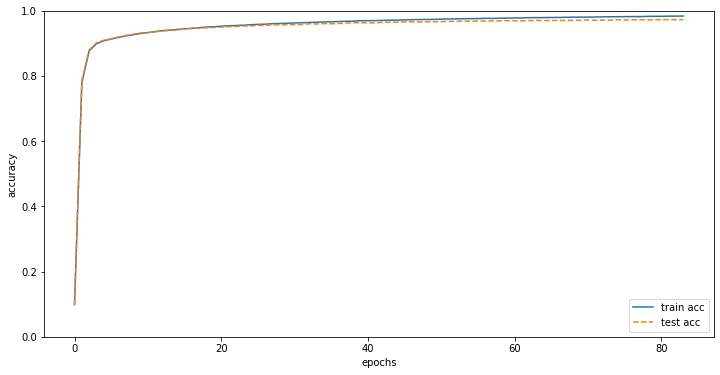

In [41]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6 

# Accuracy 그래프
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

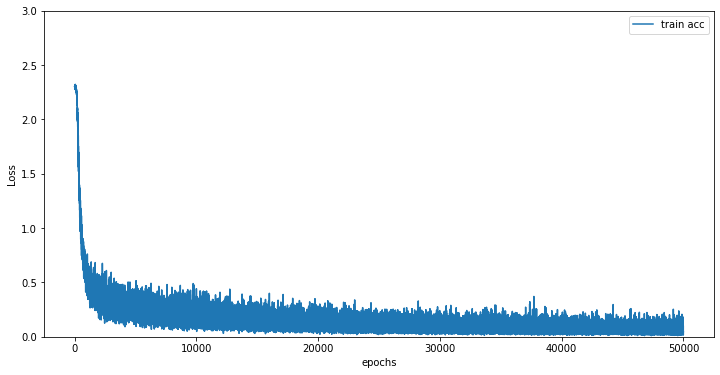

In [42]:
# Loss 그래프
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()

# 회고

__오늘은 뭣도 모르고 걍 했었던 텐서플로우 내 딥러닝 프레임워크가 어떤 원리로 작동하는지 전체적으로 살펴볼 수 있어 좋았다. 무슨 원리인지 궁금하긴 했는데 코드를 살펴볼 엄두를 못 냈는데 이렇게 오늘 노드를 통해 하나하나 해보면서 배우니까 확 와닿았던 것 같다..__

진환님이 경사하강법이랑 오차역전파법이 중요하다고 하셨는데 사실 다 이해하기까지는 아직 멀었다고 생각한다.

일단! 오늘 내가 이해한대로 정리해보면... !! 

1. 신경망 구성  : 딥러닝 신경망에는 입력층과 출력층이 있는데 그 사이에 은닉층이 존재한다. 

 - 그 은닉층이 많아질수록 깊은 학습을 진행함 각각의 층 사이에 수많은 행렬들이 존재하는데, 그게 파라미터와 가중치! 

2. 활성화 함수, 손실함수 : 
  - 또 각각의 노드를 전달할 때 그냥 전달하는 것이 아니라 활성화 함수를 통과한 다음 레이어에  전달한다. 이때 비선형 함수를 사용하는데 주로 ReLU가 합리적이기 때문에 많이 사용한다.

 - 은닉층에서 출력층으로 전달할때 정답과 정보들 사이의 오차를 계산하고 이 차이를 줄이기 위해 파라미터를 조정하는데, 이때 필요한 게 손실함수! 평균오차제곱법과 교차엔트로피가 있다.

3. 경사하강법 : 
  - 오차를 구했으니까 오차를 줄여야 하는데 이때 사용하는게 경사하강법이다. 각 단계에서의 기울기를 구해서, 기울기가 가리키는 방향으로 조금씩 이동하는데 이때 기울기 * 학습률 만큼 가게 된다.

4. 오차역전파법 :
  - 손실함수를 통해 구한 오차를 가지고 파라미터를 조정할 때, 다시 맨 앞의 입력층까지 전달하기 위해 오차역전파법을 이용한다. 각 레이어를 반대로 지나며 노드가 가진 변수들을 갱신한다.


아직 수학적인 개념까지 이해하기는 어렵다. 아마도 수학을 다시 공부해야 할듯,, 그래도 이렇게 직관적으로 보면서 배우니까 재밌게 공부했다고 생각함 ..!!! 실습하는 노드도 재밌긴 한데 이렇게 이론적인거 풀어서 설명해주는 노드 짱 ㅎㅅㅎ 아직 모르는 부분이 많은데 점점 더 정리하면서 지식을 늘려나가야겠다 ....!!!!!~!!!!!! 

